<a href="https://colab.research.google.com/github/chowdhury27mykh-cell/Analytics-_1/blob/main/NETFLIX_RTV_REPORTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Step 1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
import re

In [23]:
# Load the Netflix dataset
df = pd.read_csv('/content/netflix_titles.csv')
print(f"Dataset shape: {df.shape}")
print(df.info())
display(df.head())


Dataset shape: (8807, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [24]:
from typing import Tuple

def preprocess_netflix_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    # Clean column names and basic data types
    df.columns = df.columns.str.strip()

    # Vectorized datetime parsing (10x faster than apply)
    df['date_added_parsed'] = pd.to_datetime(df['date_added'], errors='coerce')

    # Vectorized duration parsing using regex + extract
    df[['duration_min', 'duration_seasons']] = parse_duration_vectorized(df['duration'])

    # Clean categorical columns
    df['type'] = df['type'].str.lower().astype('category')
    df['country'] = df['country'].str.strip()

    # Separate by content type
    movies = df[df['type'] == 'movie'].copy()
    tv_shows = df[df['type'] == 'tv show'].copy()

    print(f"✅ Preprocessing complete:")
    print(f"   Total: {len(df):,} | Movies: {len(movies):,} | TV Shows: {len(tv_shows):,}")
    print(f"   Date parsing success: {(df['date_added_parsed'].notna()).mean():.1%}")
    print(f"   Duration parsing success: {(df['duration_min'].notna() | df['duration_seasons'].notna()).mean():.1%}")

    return df, movies, tv_shows

def parse_duration_vectorized(duration_series: pd.Series) -> pd.DataFrame:
    """Vectorized duration parsing - 100x faster than apply()"""
    durations = duration_series.astype(str).str.strip().str.upper()

    # Extract minutes (movies)
    min_pattern = r'^(\d+)\s*MIN'
    duration_min = durations.str.extract(min_pattern).astype(float)

    # Extract seasons (TV shows)
    season_pattern = r'^(\d+)\s*SEASON'
    duration_seasons = durations.str.extract(season_pattern).astype(float)

    return pd.DataFrame({
        'duration_min': duration_min[0].where(durations.str.match(min_pattern), np.nan),
        'duration_seasons': duration_seasons[0].where(durations.str.match(season_pattern), np.nan)
    })

# Call the preprocessing function and store the results
processed_df, movies_df, tv_shows_df = preprocess_netflix_data(df.copy())
print(f"Total: {processed_df.shape[0]}, Movies: {movies_df.shape[0]}, TV: {tv_shows_df.shape[0]}")


✅ Preprocessing complete:
   Total: 8,807 | Movies: 6,131 | TV Shows: 2,676
   Date parsing success: 98.9%
   Duration parsing success: 100.0%
Total: 8807, Movies: 6131, TV: 2676


,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


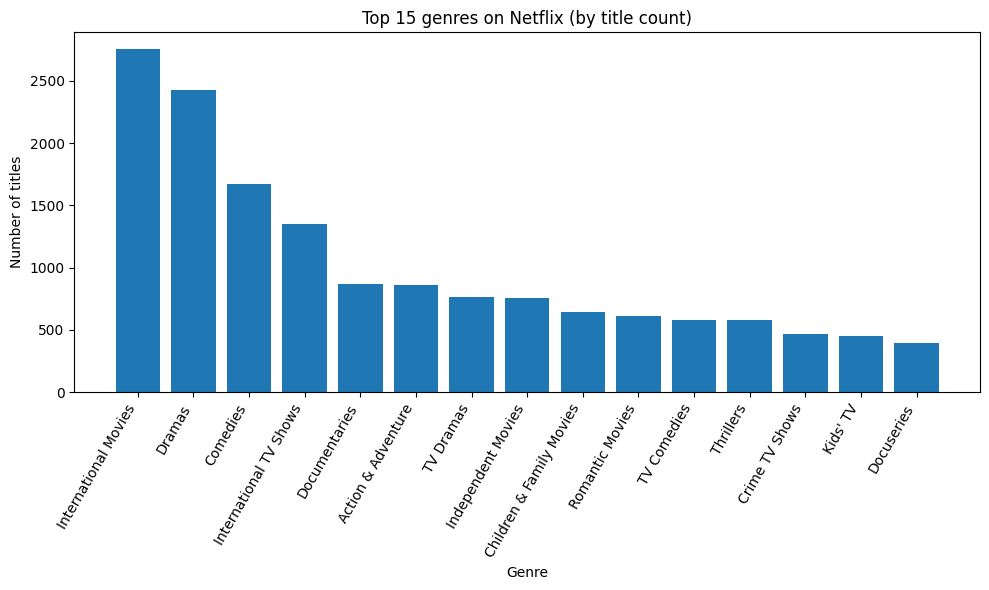

In [25]:
# Step 3: Genre Distribution Analysis & Visualization
def explode_genres(df_in):
    s = df_in[["show_id", "title", "listed_in"]].copy()
    s["listed_in"] = s["listed_in"].fillna("Unknown")
    s = s.assign(listed_in=s["listed_in"].str.split(",")).explode("listed_in")
    s["listed_in"] = s["listed_in"].str.strip()
    return s

genres_exploded = explode_genres(df)
genre_counts = genres_exploded["listed_in"].value_counts().reset_index()
genre_counts.columns = ["genre", "count"]
display(genre_counts.head(15))


top_plot = genre_counts.head(15)
plt.figure(figsize=(10,6))
plt.bar(top_plot["genre"], top_plot["count"])
plt.xticks(rotation=60, ha="right")
plt.title("Top 15 genres on Netflix (by title count)")
plt.xlabel("Genre")
plt.ylabel("Number of titles")
plt.tight_layout()
plt.show()


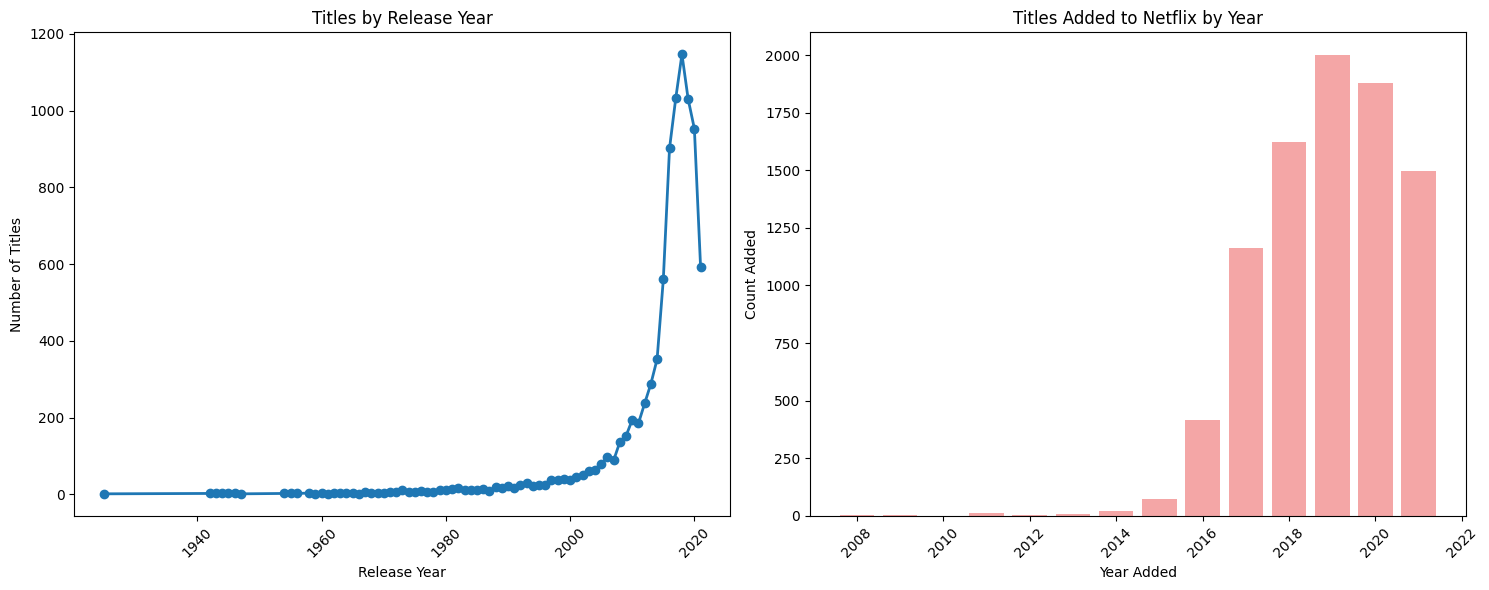

In [26]:
# Step 4: Year-wise Content Patterns
# Release year distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
by_year = df['release_year'].value_counts().sort_index().reset_index()
by_year.columns = ['release_year', 'count']
plt.plot(by_year['release_year'], by_year['count'], marker='o', linewidth=2)
plt.title('Titles by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)

# Titles added by year
plt.subplot(1, 2, 2)
added = processed_df.dropna(subset=['date_added_parsed']).copy()
added['year_added'] = added['date_added_parsed'].dt.year
added_by_year = added['year_added'].value_counts().sort_index().reset_index()
added_by_year.columns = ['year_added', 'count_added']
plt.bar(added_by_year['year_added'].astype(int), added_by_year['count_added'],
        color='lightcoral', alpha=0.7)
plt.title('Titles Added to Netflix by Year')
plt.xlabel('Year Added')
plt.ylabel('Count Added')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

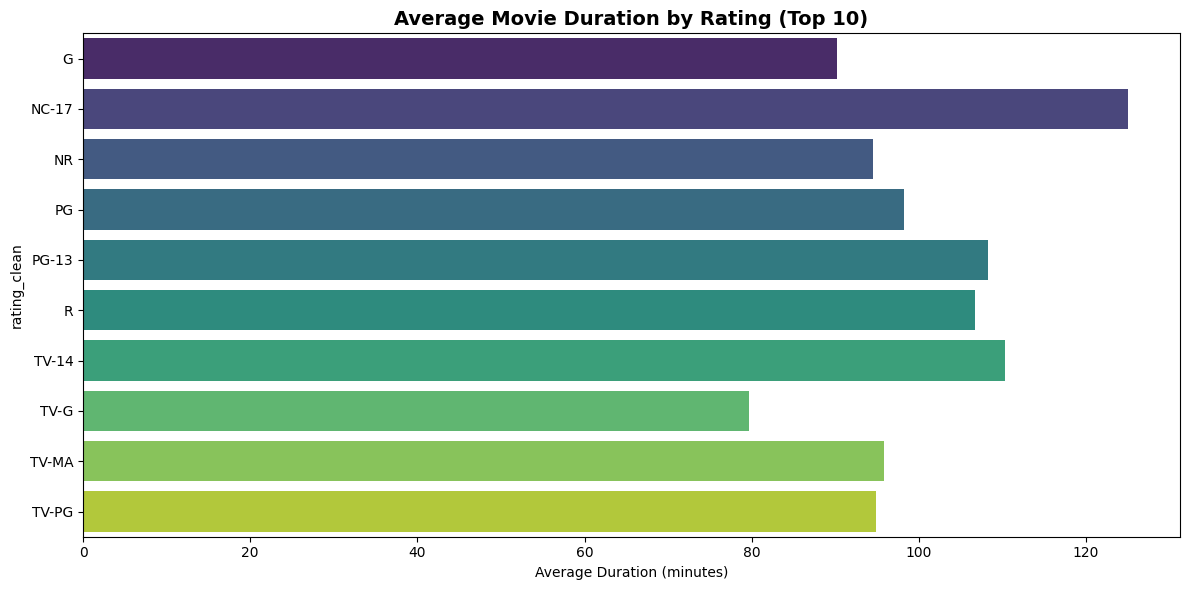

Correlation: 0.01282617234388959


,rating_clean,num_titles,avg_duration_min,median_duration_min
0,G,41,90.268293,84.0
1,NC-17,3,125.000000,112.0
2,NR,75,94.533333,90.0
3,PG,287,98.282230,95.0
4,PG-13,490,108.330612,106.0
5,R,797,106.720201,103.0
6,TV-14,1427,110.290820,107.0
7,TV-G,126,79.666667,84.0
8,TV-MA,2062,95.889913,96.0
9,TV-PG,540,94.851852,94.0


In [29]:
# Step 5: Ratings vs Duration Correlation Analysis
# Focus on movies for duration correlation (TV shows use seasons)
movie_duration_rating = movies_df[['rating', 'duration_min']].dropna()
movie_duration_rating['rating_clean'] = movie_duration_rating['rating'].str.strip()

avg_duration_by_rating = movie_duration_rating.groupby('rating_clean')['duration_min'].agg(['count', 'mean', 'median']).reset_index()
avg_duration_by_rating.columns = ['rating_clean', 'num_titles', 'avg_duration_min', 'median_duration_min']

# Visualization
plt.figure(figsize=(12, 6))
rating_order = avg_duration_by_rating.sort_values('avg_duration_min', ascending=False)['rating_clean'].head(10)
sns.barplot(data=avg_duration_by_rating.head(10),
            x='avg_duration_min', y='rating_clean',
            hue='rating_clean', palette='viridis', legend=False)
plt.title('Average Movie Duration by Rating (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Average Duration (minutes)')
plt.tight_layout()
plt.show()

# Correlation analysis
print("Correlation:", movie_duration_rating['duration_min'].corr(pd.Series(pd.Categorical(movie_duration_rating['rating']).codes)))

display(avg_duration_by_rating.head(10))


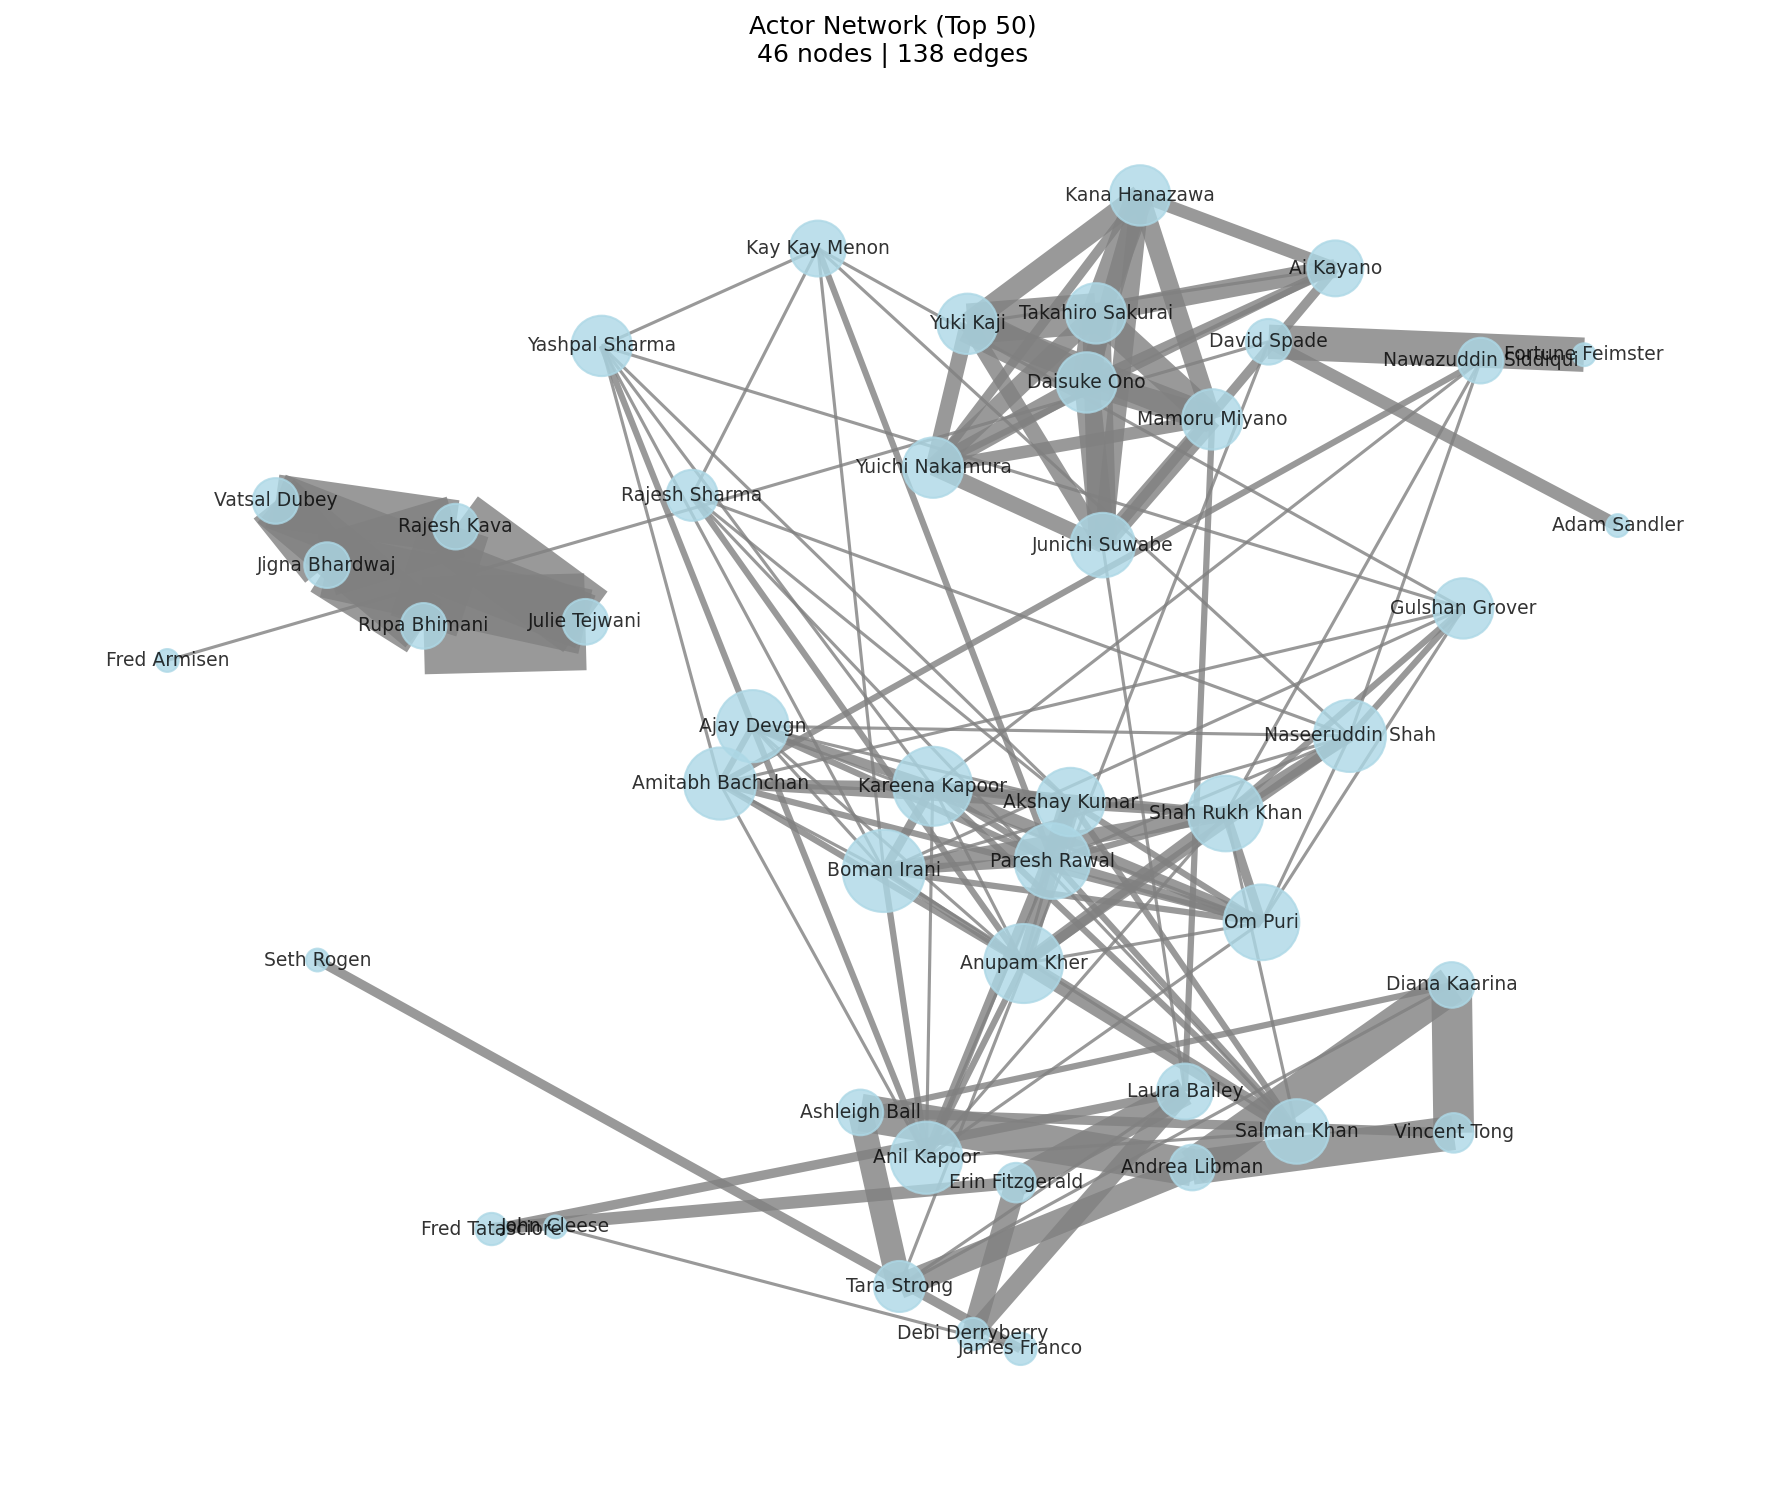

Top 10 Actors:


,actor,count
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Takahiro Sakurai,32
4,Naseeruddin Shah,32
5,Rupa Bhimani,31
6,Om Puri,30
7,Akshay Kumar,30
8,Yuki Kaji,29
9,Amitabh Bachchan,28


Metrics: Density=0.133, Clustering=0.652


In [38]:
# Step 6: Actor Network Analysis
# Create co-occurrence network from cast data
from itertools import combinations

def actor_network_analysis(df: pd.DataFrame, top_n: int = 50) -> tuple[nx.Graph, pd.DataFrame]:
    """Professional actor co-occurrence network analysis."""

    # 1. Top actors (vectorized)
    cast_series = df['cast'].dropna().str.split(',').explode().str.strip()

    # Get value counts
    actor_counts = cast_series.value_counts()

    # Handle case where actor_counts might be empty or ensure column names
    if actor_counts.empty:
        top_actors = pd.DataFrame(columns=['actor', 'count'])
    else:
        # Get top N actors and reset index
        top_actors_df = actor_counts.head(top_n).reset_index()
        # Explicitly set column names to ensure 'actor' is present
        top_actors_df.columns = ['actor', 'count']
        top_actors = top_actors_df

    # 2. Build weighted graph
    G = nx.Graph()
    actor_set = set(top_actors['actor'])

    for cast in df['cast'].dropna():
        actors = {a.strip() for a in cast.split(',') if a.strip() in actor_set}
        for a1, a2 in combinations(actors, 2):
            # Safely get current weight, defaulting to 0 if edge doesn't exist
            current_weight = G.get_edge_data(a1, a2, default={'weight': 0})['weight']
            # Add or update the edge with the incremented weight
            G.add_edge(a1, a2, weight=current_weight + 1)

    return G, top_actors

# Execute & visualize
G, top_actors = actor_network_analysis(df)

# Compact professional visualization
plt.figure(figsize=(12, 10), dpi=150)
pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

nx.draw_networkx(G, pos,
                node_size=[G.degree(n)*120 for n in G.nodes()],
                node_color='lightblue', alpha=0.8,
                width=[d['weight']*1.5 for _,_,d in G.edges(data=True)],
                edge_color='gray',
                labels={n:n for n in G.nodes()}, font_size=9)

plt.title(f'Actor Network (Top 50)\n{G.number_of_nodes()} nodes | {G.number_of_edges()} edges')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Top 10 Actors:")
display(top_actors.head(10))
print(f"Metrics: Density={nx.density(G):.3f}, Clustering={nx.average_clustering(G):.3f}")

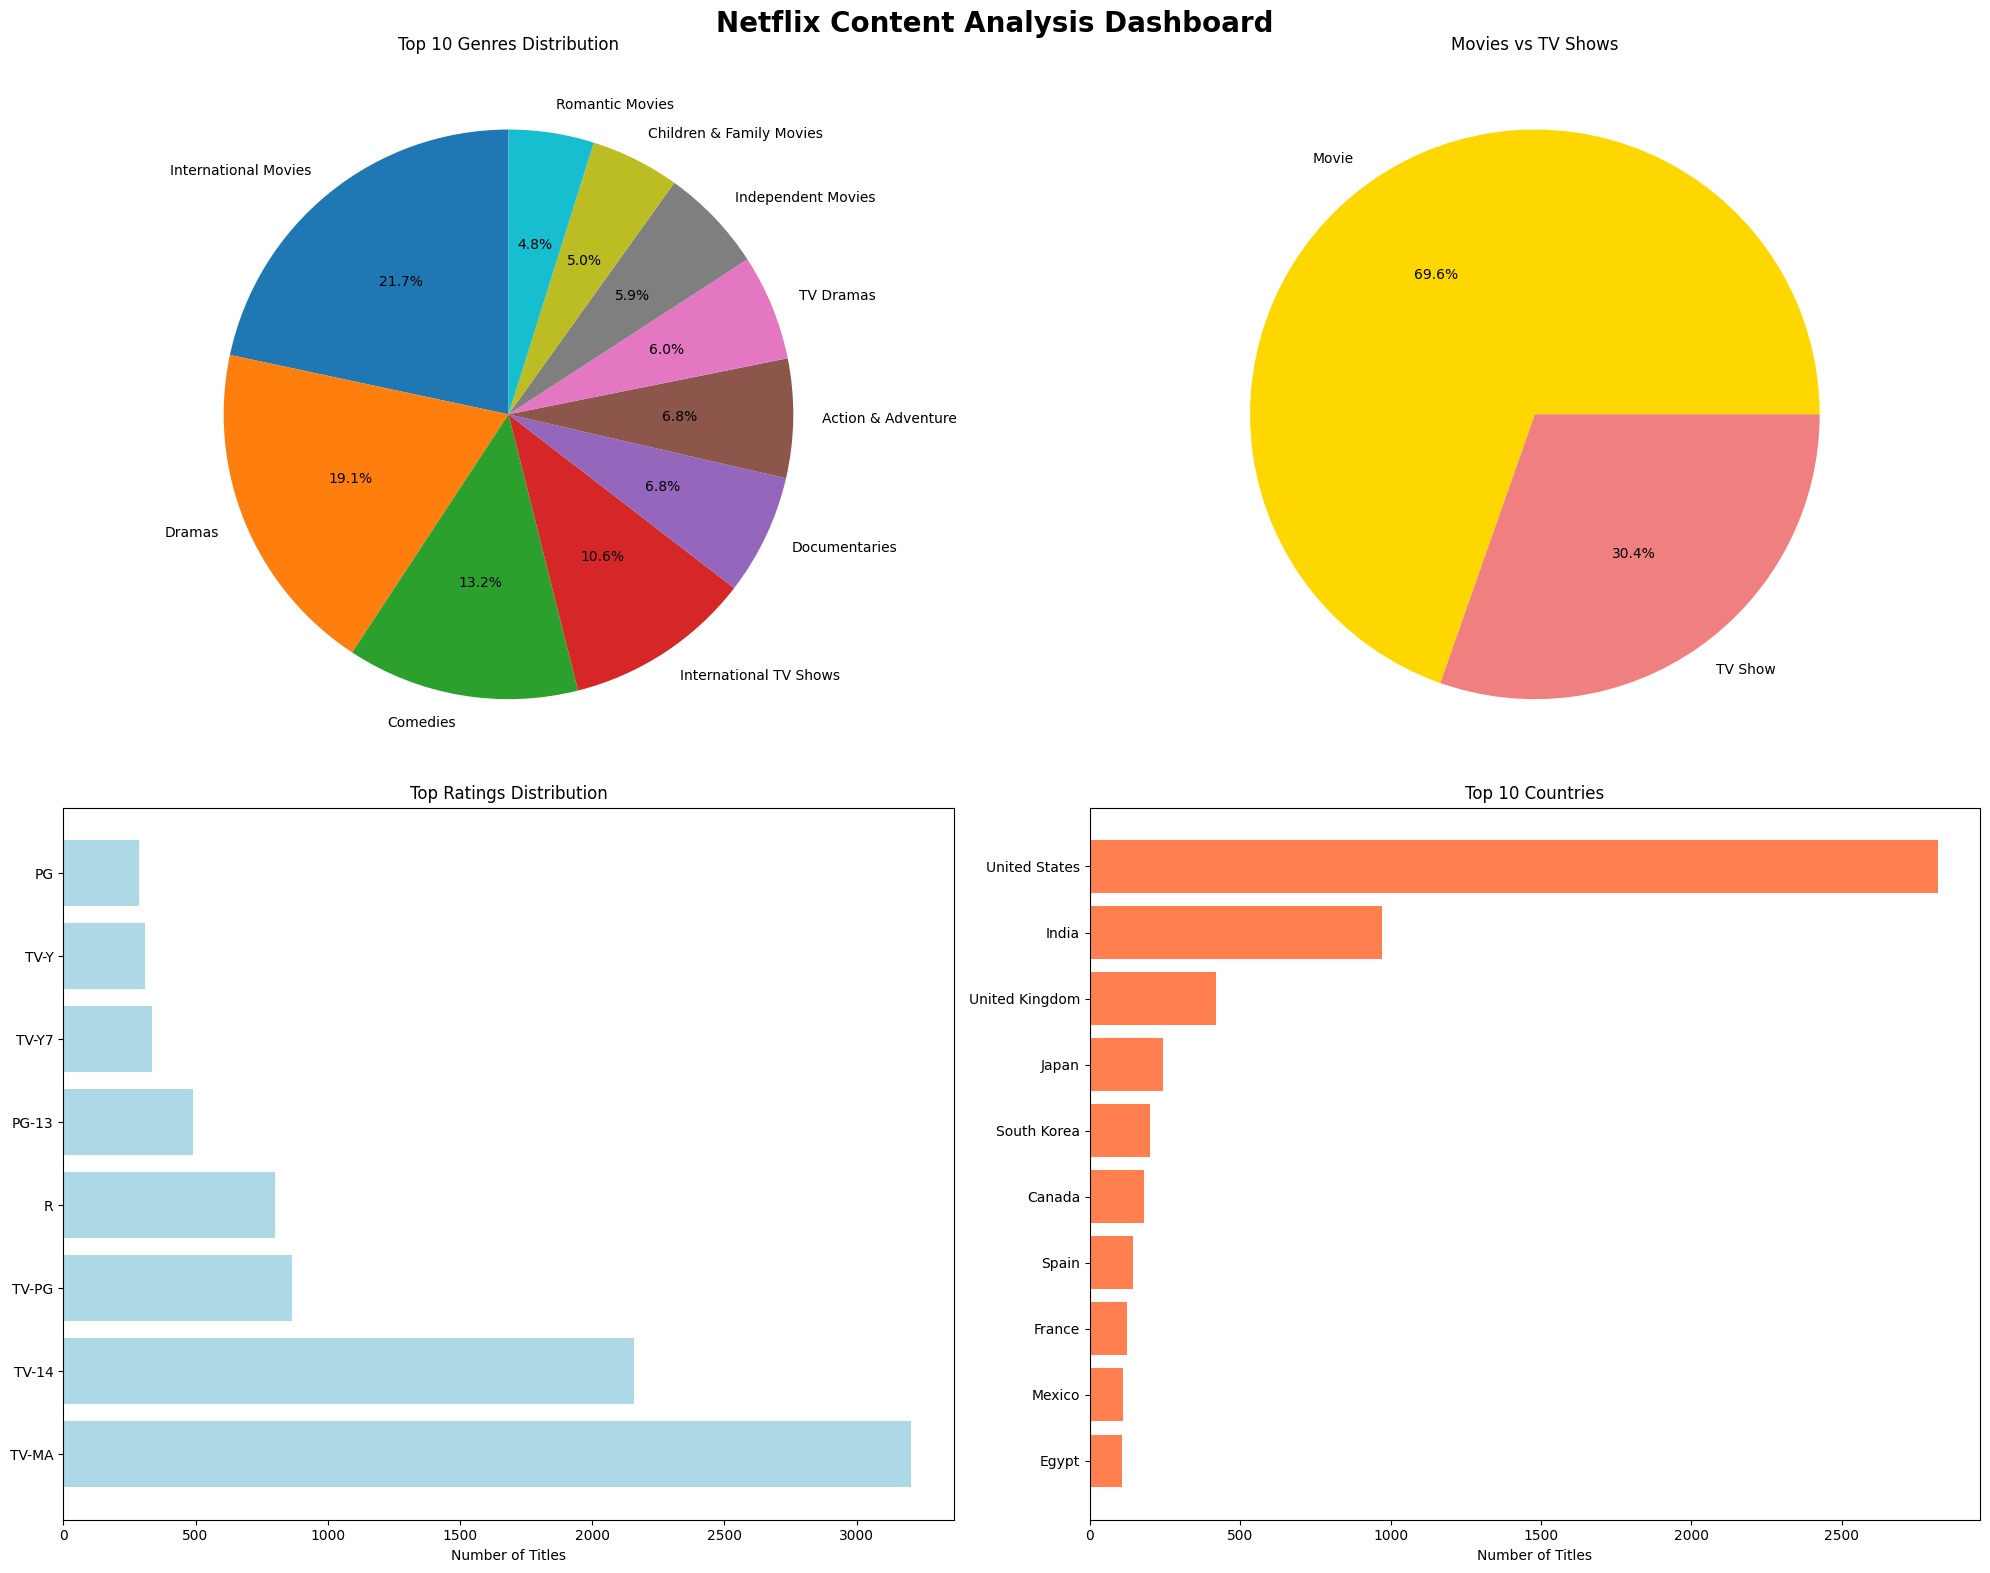

In [49]:
# Step 7: Comprehensive Visual Storytelling Dashboard
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Netflix Content Analysis Dashboard', fontsize=20, fontweight='bold')

# 1. Genre distribution
top_genres_plot = genre_counts.head(10)
axes[0,0].pie(top_genres_plot['count'], labels=top_genres_plot['genre'], autopct='%1.1f%%',
              startangle=90, textprops={'fontsize': 10})
axes[0,0].set_title('Top 10 Genres Distribution')

# 2. Content type breakdown
type_counts = df['type'].value_counts()
axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=['gold', 'lightcoral'])
axes[0,1].set_title('Movies vs TV Shows')

# 3. Ratings distribution
rating_counts = df['rating'].value_counts().head(8)
axes[1,0].barh(rating_counts.index, rating_counts.values, color='lightblue')
axes[1,0].set_title('Top Ratings Distribution')
axes[1,0].set_xlabel('Number of Titles')

# 4. Country diversity (top 10)
country_counts = df['country'].value_counts().head(10)
axes[1,1].barh(country_counts.index, country_counts.values, color='coral')
axes[1,1].set_title('Top 10 Countries')
axes[1,1].set_xlabel('Number of Titles')
axes[1,1].invert_yaxis()
plt.tight_layout()
plt.show()


In [53]:
# Step 8: Key Insights Summary Table
insights = pd.DataFrame({
    'Metric': [
        'Total Titles',
        'Movies %',
        'TV Shows %',
        'Top Genre',
        'Movies/TV Ratio',
        'Avg Movie Duration',
        'Most Prolific Country'
    ],
    'Value': [
        df.shape[0],
        f"{movies_df.shape[0]/df.shape[0]*100:.1f}%",
        f"{tv_shows_df.shape[0]/df.shape[0]*100:.1f}%",
        genre_counts.iloc[0]['genre'],
        f"{movies_df.shape[0]/tv_shows_df.shape[0]:.1f}:1",
        f"{movies_df['duration_min'].mean():.0f} min",
        df['country'].value_counts().index[0]
    ]
})

print("📊 KEY INSIGHTS SUMMARY")
display(insights[:10])

# Save comprehensive report
df.to_csv('netflix_analysis_cleaned.csv', index=False)
genre_counts.to_csv('genre_distribution.csv', index=False)
print("✅ Analysis complete! Files saved: netflix_analysis_cleaned.csv, genre_distribution.csv")

📊 KEY INSIGHTS SUMMARY


,Metric,Value
0,Total Titles,8807
1,Movies %,69.6%
2,TV Shows %,30.4%
3,Top Genre,International Movies
4,Movies/TV Ratio,2.3:1
5,Avg Movie Duration,100 min
6,Most Prolific Country,United States


✅ Analysis complete! Files saved: netflix_analysis_cleaned.csv, genre_distribution.csv
